In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from uuid import uuid4

import pandas as pd
import numpy as np
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from tqdm.auto import tqdm

sys.path.append("..")
from sgs_utils.path_conf import (
    loc_data_dir,
    speech_data_root_dir,
    speech_data_session_dir,
)

In [3]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_uuid.parquet"))

In [4]:
extracted_embeddings = True

# Use the `ECAPA-TDNN` architecture to extract embeddings

In [5]:
if not extracted_embeddings:
    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    uuid_embedding = {}

    for _, row in tqdm(list(df_session.iterrows())):
        signal, fs = torchaudio.load(
            list(
                list(speech_data_session_dir.glob(f"*{row.ID}*"))[0]
                .joinpath(row.DB)
                .glob(f"*{row.time_str}*.wav")
            )[0],
            channels_first=False,
        )
        if signal.size()[0] == 0:
            continue
        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .numpy()
            .ravel()
        )

    df_emb = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb.index.name = "uuid"
    df_emb.index = df_emb.index.astype("str")
    del row, signal, fs, uuid_embedding

    df_emb.to_parquet(loc_data_dir.joinpath("uuid_emb.parquet"))

else:
    df_emb = pd.read_parquet(loc_data_dir.joinpath("uuid_emb.parquet"))

In [7]:
df_emb.head(2)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
uuid,,,,,,,,,,,,,,,,,,,,,
584871ea-39d4-41fe-80f4-1f602bab38f6,-29.735306,28.870380,-7.721382,-2.163693,15.799279,-12.133603,4.848145,15.863859,32.329247,-4.506712,...,-7.108490,12.071738,13.764357,-1.152337,-19.221605,11.216951,-2.520880,14.563207,29.833864,4.312611
206f620d-6c5e-48fd-adff-f44aa4fbb48c,-27.537552,8.651269,-7.450596,-2.576056,10.251927,-10.824473,21.281967,29.855698,30.608610,-13.781198,...,-11.329093,6.115922,31.284086,27.954758,-7.563572,29.465097,5.591878,14.258314,10.912814,4.384069


# Merge the embeddings with the session data

In [8]:
df_tot = pd.merge(df_session, df_emb.reset_index(), on=["uuid"])
df_tot

,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,pic_name,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,marloes,...,-7.108490,12.071738,13.764357,-1.152337,-19.221605,11.216951,-2.520880,14.563207,29.833864,4.312611
1,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 105,...,-11.329093,6.115922,31.284086,27.954758,-7.563572,29.465097,5.591878,14.258314,10.912814,4.384069
2,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_24_Caucasian_male_neutral_frontal,...,-26.330000,-5.139002,38.220707,15.530716,-2.335446,3.851423,-1.272228,7.434868,4.015074,-15.379352
3,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 82,...,4.304005,20.435759,25.857384,17.855526,-5.828025,9.242198,23.921484,7.689347,34.666264,18.014544
4,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_33_Caucasian_male_neutral_frontal,...,-5.603549,12.006181,33.583004,8.054292,1.245866,-5.431492,14.768291,5.772975,28.125410,0.537898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 80,...,-21.482824,27.795372,-39.390953,14.513519,18.173910,-19.711973,-3.821543,-6.437921,-23.122677,9.666133
1131,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Rafd090_36_Caucasian_male_neutral_frontal,...,-6.808029,21.008289,-39.891201,22.018450,19.344896,-17.532471,8.937469,2.978209,-21.796703,2.103698
1132,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 105,...,-22.812651,24.275648,-36.314831,18.945385,19.263029,-26.497717,6.591331,-1.799583,-24.474585,10.668737
1133,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Rafd090_01_Caucasian_female_neutral_frontal,...,-21.230827,21.326614,-36.082111,16.821020,17.867558,-6.244754,3.824248,-1.546594,-25.649067,7.933518


In [10]:
df_tot["speech_style"] = df_tot.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

In [11]:
df_tot.filter(like="emb_").head(n=3)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,-29.735306,28.870380,-7.721382,-2.163693,15.799279,-12.133603,4.848145,15.863859,32.329247,-4.506712,...,-7.108490,12.071738,13.764357,-1.152337,-19.221605,11.216951,-2.520880,14.563207,29.833864,4.312611
1,-27.537552,8.651269,-7.450596,-2.576056,10.251927,-10.824473,21.281967,29.855698,30.608610,-13.781198,...,-11.329093,6.115922,31.284086,27.954758,-7.563572,29.465097,5.591878,14.258314,10.912814,4.384069
2,-26.542862,-2.001462,-7.376048,8.858932,16.296469,-28.526564,14.828238,40.838581,3.677034,-14.097603,...,-26.330000,-5.139002,38.220707,15.530716,-2.335446,3.851423,-1.272228,7.434868,4.015074,-15.379352


# Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [12]:
from sklearn.manifold import TSNE

In [13]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity=100)  # perplexity = # allowed nearest neighbours
tsne_result = tsne.fit_transform(df_tot.filter(like="emb_"))


def construct_tsne_df(tnse_result: np.ndarray, label_col: str) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tsne_result).add_prefix("tsne_")
    tsne_result_df[label_col] = df_tot[label_col]
    return tsne_result_df

/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Visualize TSNE

In [15]:
import seaborn as sns
sns.set_context('talk')

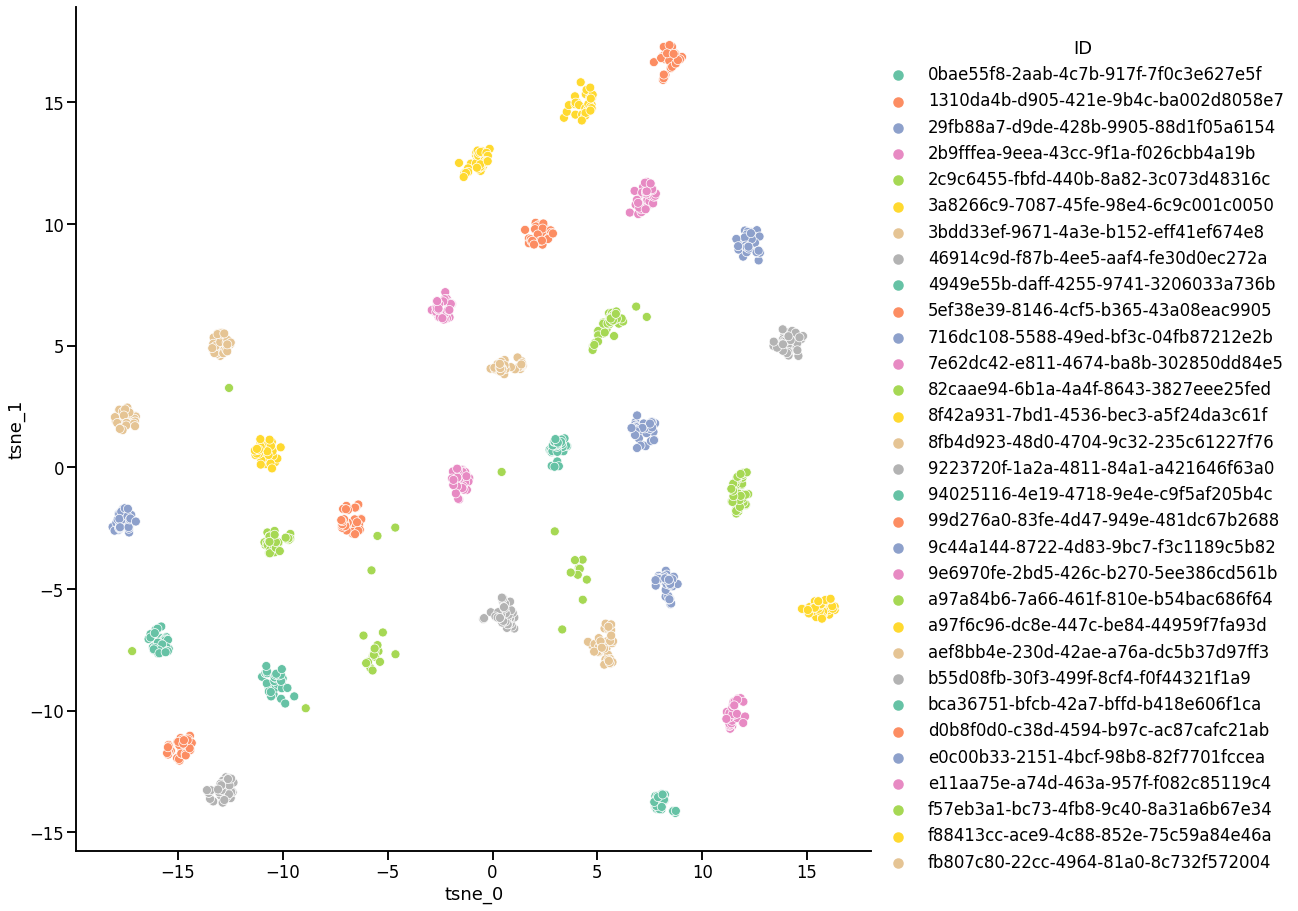

In [16]:
label_col = 'ID'
sns.relplot(
    data=construct_tsne_df(tsne_result, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

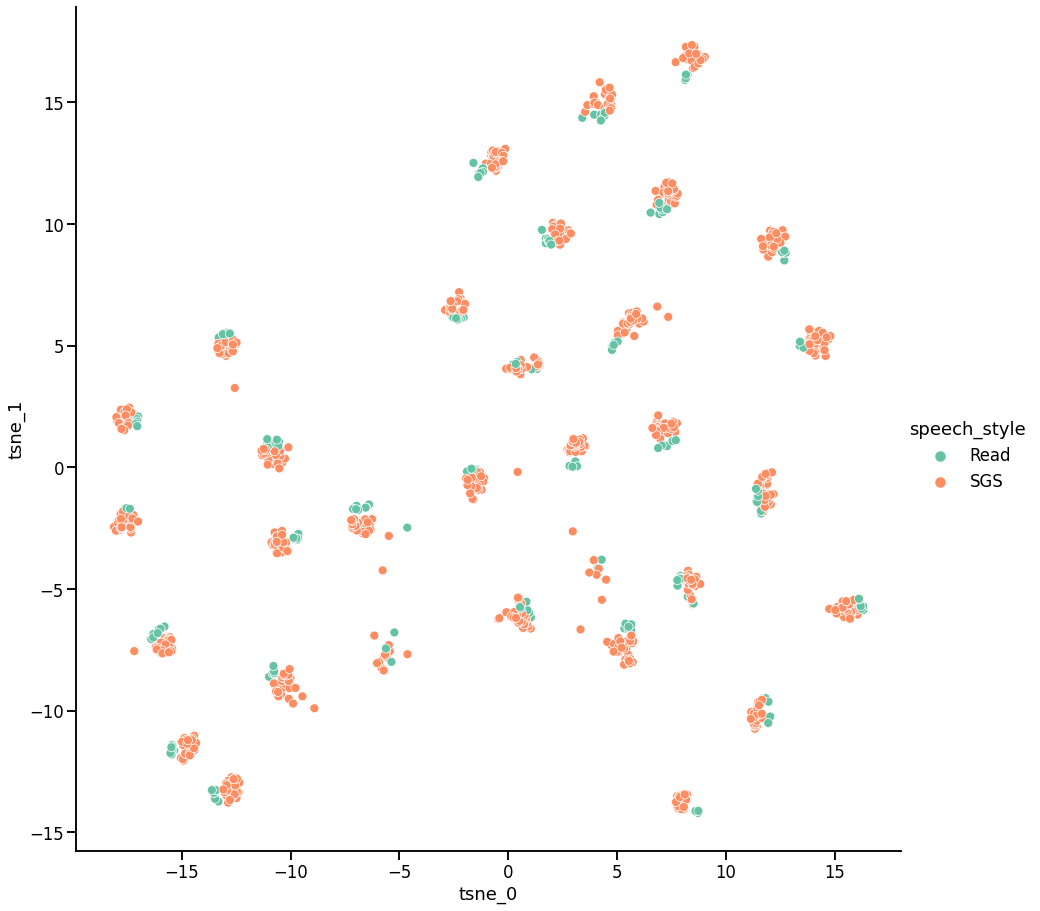

In [18]:
label_col = "speech_style"
sns.relplot(
    data=construct_tsne_df(tsne_result, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

# Testing `speech-style` seperability 

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

In [25]:
df_tot["speech_style"].values

array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [26]:
model = Pipeline(
    [
        # ("scaling", RobustScaler()),
        ("scaling", PowerTransformer()),
        # ('lda', LinearDiscriminantAnalysis(tol=1e-1)),
        # ("lr", LogisticRegression(C=1))
        ("lr", LogisticRegression(C=1)),# class_weight='balanced'))
        # (
        #     "rf",
        #     RandomForestClassifier(
        #         class_weight="balanced",
        #         max_depth=3, max_samples=.5
        #     ),
        # )
    ]
)

cross_val_score(
    estimator=model,
    X=df_tot.filter(like="emb_"),
    y=df_tot["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_tot["ID"],
)

/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


array([0.81927398, 0.78028342, 0.72108939, 0.79983649, 0.74390244])

In [27]:
X = df_tot.filter(like="emb_").values
y = df_tot["speech_style"].values
groups = df_tot["ID"]

/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/users/jonvdrdo/.cache/pypoetry/virtualenvs/semi-guided-speech-4tfDKop0-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


              precision    recall  f1-score   support

        Read       0.39      0.98      0.56        46
         SGS       0.99      0.66      0.79       209

    accuracy                           0.72       255
   macro avg       0.69      0.82      0.67       255
weighted avg       0.88      0.72      0.75       255



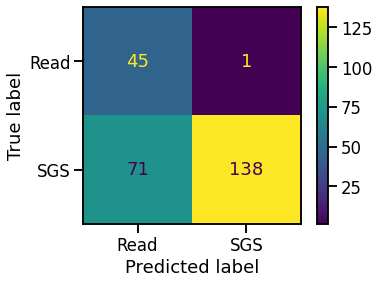

              precision    recall  f1-score   support

        Read       0.47      0.76      0.58        41
         SGS       0.94      0.80      0.86       179

    accuracy                           0.80       220
   macro avg       0.70      0.78      0.72       220
weighted avg       0.85      0.80      0.81       220



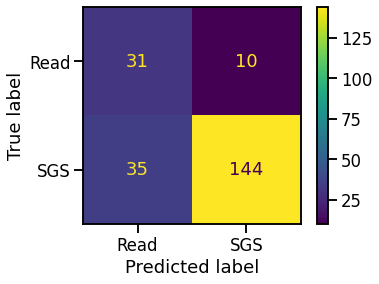

              precision    recall  f1-score   support

        Read       0.32      0.85      0.46        40
         SGS       0.95      0.59      0.73       179

    accuracy                           0.64       219
   macro avg       0.63      0.72      0.60       219
weighted avg       0.83      0.64      0.68       219



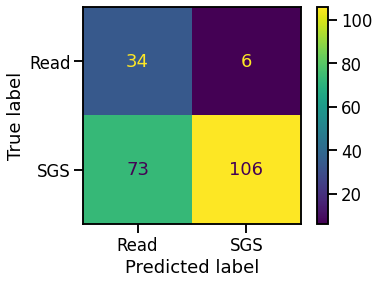

              precision    recall  f1-score   support

        Read       0.53      0.76      0.62        41
         SGS       0.94      0.84      0.89       179

    accuracy                           0.83       220
   macro avg       0.73      0.80      0.75       220
weighted avg       0.86      0.83      0.84       220



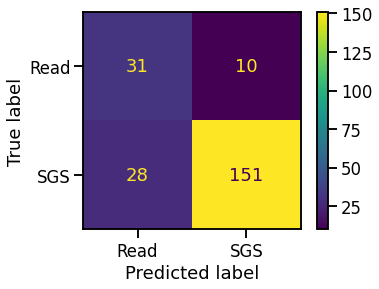

              precision    recall  f1-score   support

        Read       1.00      0.49      0.66        41
         SGS       0.90      1.00      0.94       180

    accuracy                           0.90       221
   macro avg       0.95      0.74      0.80       221
weighted avg       0.91      0.90      0.89       221



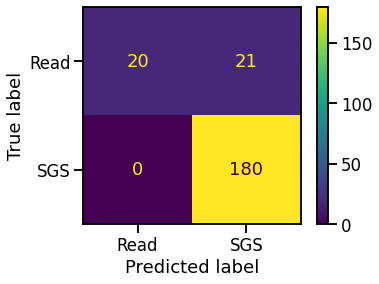

In [28]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(model, x_test_cv_, y[test_idx])
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    # aucs += [roc_auc_score(y[test_idx], preds_proba)]